In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install split-folders

# Imports

## Globals

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
# import splitfolders

warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython import get_ipython
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')

In [11]:
BASE_DIR = '/My Drive/trash/'
print(os.curdir()) 
os.chdir(BASE_DIR)


TypeError: ignored

In [ ]:
###################################### data preparation (just 1 time)

if not os.path.exists("ds_trashnet_split"):
  splitfolders.ratio("ds_trashnet_resized", output="ds_trashnet_split", seed=1337, ratio=(.7, .13, .17), group_prefix=None)


## TensorBoard

Using TensorBoard tool to mantain logs

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
from datetime import datetime
from packaging import version

# Helper functions

## Plot images

In [ ]:
# plots half of a batches because of screen space visualization issue
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 16, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Confusion Matrix

In [ ]:
# plot the confusion matrix (scikit-learn copied)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Dataset

In [1]:
#paths for train, val and test

DATA_DIR = BASE_DIR + 'ds_trashnet_split/'

train_path = DATA_DIR + 'train'
valid_path = DATA_DIR + 'val'
test_path = DATA_DIR + 'test'

NameError: ignored

In [2]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(256, 256), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=32)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(256, 256), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=32)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(256, 256), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=32, shuffle=False)


NameError: ignored

In [ ]:
imgs, labels = next(train_batches)

In [ ]:
plotImages(imgs)
print(labels)

# Model

## Set the tensorboard log directory

In [ ]:
logdir = "logs/scalars/AlexNet" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


## Create and complie

In [ ]:
# ######################################### build and train

# creazione del modello
# padding = 'same' equivale allo zero-padding
# input_shape = (dim1, dim2, num_color_channels)
model = Sequential([
    Conv2D(filters=96, kernel_size=(11, 11), activation='relu', padding='same', strides=(4,4), input_shape=(256, 256, 3)),
    MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),
    Conv2D(filters=192, kernel_size=(5, 5), activation='relu', padding='same', strides=(1,1)),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Conv2D(filters=288, kernel_size=(3, 3), activation='relu', padding='same', strides=(1,1)),
    Conv2D(filters=288, kernel_size=(3, 3), activation='relu', padding='same', strides=(1,1)),
    Conv2D(filters=192, kernel_size=(3, 3), activation='relu', padding='same', strides=(1,1)),
    MaxPool2D(pool_size=(3, 3), strides=2, padding='valid'),
    Flatten(),
    Dense(units=4096,  input_shape=(256, 256, 3), activation='relu'),
    Dense(units=4096, activation='relu'),
    Dense(units=6, activation='softmax') 
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 192)       460992    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 288)       497952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 288)       746784    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 192)       4

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), #
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


## Train

In [ ]:
# train: uso della funzione fit

history = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=60,
          verbose=2,
          callbacks=[tensorboard_callback])

Epoch 1/60
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
56/56 - 13s - loss: 2.8758 - categorical_accuracy: 0.3788 - precision: 0.5286 - recall: 0.1727 - val_loss: 1.2733 - val_categorical_accuracy: 0.5460 - val_precision: 0.6262 - val_recall: 0.3957
Epoch 2/60
56/56 - 12s - loss: 1.0926 - categorical_accuracy: 0.5815 - precision: 0.7318 - recall: 0.4156 - val_loss: 1.0448 - val_categorical_accuracy: 0.6288 - val_precision: 0.7906 - val_recall: 0.4632
Epoch 3/60
56/56 - 12s - loss: 0.9416 - categorical_accuracy: 0.6569 - precision: 0.7753 - recall: 0.5294 - val_loss: 0.9567 - val_categorical_accuracy: 0.6442 - val_precision: 0.8221 - val_recall: 0.5245
Epoch 4/60
56/56 - 12s - loss: 0.7112 - categorical_accuracy: 0.7537 - precision: 0.8348 - recall: 0.6523 - val_loss: 0.9975 - val_categorical_accuracy: 0.6472 - val_precision: 0.7500 - val_recall: 0.5982
Epoch 5/60
56/56 - 12s - loss: 0.5362 - categorical_accuracy: 0.8063 - precision: 0.8675 - recall: 0.7452 - 

In [ ]:
print("Training stats:")
loss, acc, prec, rec = model.evaluate(train_batches, steps = len(train_batches))
print("Validation stats:")
loss, acc, prec, rec = model.evaluate(valid_batches, steps = len(valid_batches))

## TensordBoard plots and graphs

In [ ]:
%tensorboard --logdir logs/scalars/AlexNet20201018-082318
 

## Save model

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('TrashNet_AlexNet_revisione_model.h5') 

# Load model

In [3]:
os.chdir(BASE_DIR)
!ls

NameError: ignored

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('TrashNet_AlexNet_revisione_model.h5')

# Show the model architecture
model.summary()


print("Training stats:")
loss, acc, prec, rec = model.evaluate(train_batches, steps = len(train_batches))
print("Validation stats:")
loss, acc, prec, rec = model.evaluate(valid_batches, steps = len(valid_batches))

# Predictions

In [ ]:
# generates predictions on the test set
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=1)

14/14 [==============================] - 152s 12s/step


In [ ]:
# shows rounded predictions
np.round(predictions)

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
    # np.argmax transform the one hot encoded labels in 1 or 0 to be
    # in the same format as the true labels
# access to the true labels in the test set
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

### Plot and results

In [ ]:
# is to show which indices are assigned to which class
test_batches.class_indices


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

Confusion matrix, without normalization
[[53  3  2  6  3  2]
 [ 5 59  6  1 12  3]
 [ 2  8 54  3  3  0]
 [ 3  6  1 86  6  0]
 [ 6  9  6  4 55  3]
 [ 1  2  0  2  3 17]]


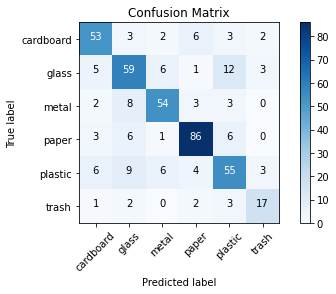

In [ ]:
cm_plot_labels = ['cardboard','glass','metal', 'paper', 'plastic', 'trash']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
print(model.metrics_names)
result = model.evaluate(test_batches, steps = len(test_batches))

['loss', 'categorical_accuracy', 'precision', 'recall']
14/14 [==============================] - 2s 154ms/step - loss: 1.8237 - categorical_accuracy: 0.7448 - precision: 0.7552 - recall: 0.7448


In [ ]:
print("Test-set categorical accuracy: {0:.2%}".format(result[1]))
print("Test-set precision: {0:.2%}".format(result[2]))
print("Test-set recall: {0:.2%}".format(result[3]))

Test-set categorical accuracy: 74.48%
Test-set precision: 75.52%
Test-set recall: 74.48%


In [ ]:
#classification report of precision and recall for each class
print(test_batches.class_indices)
print()
print(classification_report(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)))

report = classification_report(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1), output_dict= True)


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

              precision    recall  f1-score   support

           0       0.76      0.77      0.76        69
           1       0.68      0.69      0.68        86
           2       0.78      0.77      0.78        70
           3       0.84      0.84      0.84       102
           4       0.67      0.66      0.67        83
           5       0.68      0.68      0.68        25

    accuracy                           0.74       435
   macro avg       0.74      0.74      0.74       435
weighted avg       0.74      0.74      0.74       435



In [ ]:
import pandas as pd 

df = pd.DataFrame(report).transpose()
df.to_csv('report_AN_TN.csv', index = False)

# Test with my own dataset

In [ ]:
os.chdir(BASE_DIR)

In [ ]:
my_test_path = BASE_DIR + 'ds_mytest_AN/'

my_test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=my_test_path, target_size=(256, 256), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=32, shuffle=False)


Found 94 images belonging to 6 classes.


In [ ]:
my_test_imgs, my_test_labels = next(my_test_batches)
# estrae immagini con corrispondenti label; ricorda che il test set è ordinato
# plotImages(my_test_imgs)
# print(my_test_labels)

In [ ]:
# generates predictions on the test set
my_preds = model.predict(x=my_test_batches, steps=len(my_test_batches), verbose=1)

3/3 [==============================] - 28s 14s/step


In [ ]:
# shows rounded predictions
# np.round(preds)

## Plots and results

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true=my_test_batches.classes, y_pred=np.argmax(my_preds, axis=-1))
    # np.argmax transform the one hot encoded labels in 1 or 0 to be
    # in the same format as the true labels
# access to the true labels in the test set
my_test_batches.classes


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5], dtype=int32)

Confusion matrix, without normalization
[[4 2 1 4 4 0]
 [5 1 0 4 1 0]
 [3 2 3 3 0 0]
 [7 0 3 2 3 0]
 [5 3 6 7 5 0]
 [3 1 3 5 4 0]]


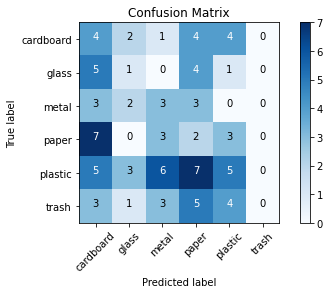

In [ ]:
cm_plot_labels = ['cardboard', 'glass','metal', 'paper', 'plastic', 'trash']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
result = model.evaluate(my_test_batches, steps = len(my_test_batches))
print("My test-set categorical accuracy: {0:.2%}".format(result[1]))
print("Precision: {0:.2%}".format(result[2]))
print("Recall: {0:.2%}".format(result[3]))

3/3 [==============================] - 1s 192ms/step - loss: 10.0873 - categorical_accuracy: 0.1596 - precision: 0.1556 - recall: 0.1489
My test-set categorical accuracy: 15.96%
Precision: 15.56%
Recall: 14.89%


In [ ]:
#classification report of precision and recall for each class
print(my_test_batches.class_indices)
print(classification_report(y_true=my_test_batches.classes, y_pred=np.argmax(my_preds, axis=-1)))
report = classification_report(y_true=my_test_batches.classes, y_pred=np.argmax(my_preds, axis=-1), output_dict= True)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
              precision    recall  f1-score   support

           0       0.15      0.27      0.19        15
           1       0.11      0.09      0.10        11
           2       0.19      0.27      0.22        11
           3       0.08      0.13      0.10        15
           4       0.29      0.19      0.23        26
           5       0.00      0.00      0.00        16

    accuracy                           0.16        94
   macro avg       0.14      0.16      0.14        94
weighted avg       0.15      0.16      0.15        94



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd 

df = pd.DataFrame(report).transpose()
df.to_csv('report_AN_Test.csv', index = False)

# Test: background augmentation

In [ ]:
os.chdir(BASE_DIR)

In [ ]:
bg_test_path = BASE_DIR + 'ds_trashnet_new_bg/'

bg_test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=bg_test_path, target_size=(256, 256), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=32, shuffle=False)


Found 94 images belonging to 6 classes.


In [ ]:
bg_test_imgs, bg_test_labels = next(bg_test_batches)
# estrae immagini con corrispondenti label; ricorda che il test set è ordinato
# plotImages(bg_test_imgs)
# print(bg_test_labels)

In [ ]:
# generates predictions on the test set
bg_preds = model.predict(x=bg_test_batches, steps=len(bg_test_batches), verbose=1)

3/3 [==============================] - 28s 14s/step


In [ ]:
# shows rounded predictions
# np.round(preds)

## Plots and results

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true=bg_test_batches.classes, y_pred=np.argmax(bg_preds, axis=-1))
    # np.argmax transform the one hot encoded labels in 1 or 0 to be
    # in the same format as the true labels
# access to the true labels in the test set
bg_test_batches.classes


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5], dtype=int32)

Confusion matrix, without normalization
[[4 2 1 4 4 0]
 [5 1 0 4 1 0]
 [3 2 3 3 0 0]
 [7 0 3 2 3 0]
 [5 3 6 7 5 0]
 [3 1 3 5 4 0]]


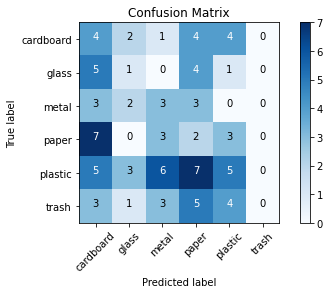

In [ ]:
cm_plot_labels = ['cardboard', 'glass','metal', 'paper', 'plastic', 'trash']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
result = model.evaluate(bg_test_batches, steps = len(bg_test_batches))
print("MCategorical accuracy: {0:.2%}".format(result[1]))
print("Precision: {0:.2%}".format(result[2]))
print("Recall: {0:.2%}".format(result[3]))

3/3 [==============================] - 1s 192ms/step - loss: 10.0873 - categorical_accuracy: 0.1596 - precision: 0.1556 - recall: 0.1489
My test-set categorical accuracy: 15.96%
Precision: 15.56%
Recall: 14.89%


In [ ]:
#classification report of precision and recall for each class
print(bg_test_batches.class_indices)
print(classification_report(y_true=bg_test_batches.classes, y_pred=np.argmax(bg_preds, axis=-1)))
report = classification_report(y_true=bg_test_batches.classes, y_pred=np.argmax(bg_preds, axis=-1), output_dict= True)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
              precision    recall  f1-score   support

           0       0.15      0.27      0.19        15
           1       0.11      0.09      0.10        11
           2       0.19      0.27      0.22        11
           3       0.08      0.13      0.10        15
           4       0.29      0.19      0.23        26
           5       0.00      0.00      0.00        16

    accuracy                           0.16        94
   macro avg       0.14      0.16      0.14        94
weighted avg       0.15      0.16      0.15        94



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd 

df = pd.DataFrame(report).transpose()
df.to_csv('report_AN_BG.csv', index = False)